In [114]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Simulation parameters

In [115]:
# --- dBm <-> Watts 변환 함수 ---
def dbm_to_watts(dbm):
    return (10**(dbm / 10)) / 1000

def watts_to_dbm(watts):
    epsilon = 1e-30     # 0에 가까운 값 방지를 위해 작은 값(epsilon) 처리
    return 10 * np.log10((watts + epsilon) * 1000)

def calculate_path_loss_db(distance_m, f_c_hz):
    c = 3.0e8
    lambda_wave = c / f_c_hz

    # 0m 거리 방지를 위한 epsilon
    epsilon = 1e-9
    path_loss_linear = ((4 * np.pi * (distance_m + epsilon)) / lambda_wave)**2
    path_loss_db = 10 * np.log10(path_loss_linear)
    return path_loss_db

# 송신 전력 (Pt) (단위: dBm)
p_t_dbm = 10.0
f_c = 3.5e9
D_tx_rx = 50.0  # Tx-Rx 거리 (m)
A_normalized = 2.0
grid_points = 200

# 송신(Tx) 및 수신(Rx) 경로의 수
L_t = 3
L_r = 3 # 시각화 그리드 해상도

# --- 시뮬레이션용 고정 파라미터 ---
t_pos_fixed = np.array([0.0, 0.0])
c = 3.0e8
lambda_wave = c / f_c
A = A_normalized * lambda_wave
p_t_watts = dbm_to_watts(p_t_dbm)

# --- 대규모(Large-Scale) 경로 손실 계산 ---
path_loss_db = calculate_path_loss_db(D_tx_rx, f_c)

print(f"--- 시뮬레이션 파라미터 ---")
print(f"송신 전력 (P_t): {p_t_dbm:.2f} dBm (={p_t_watts:.4f} W)")
print(f"주파수 (f_c): {f_c/1e9:.2f} GHz (파장: {lambda_wave:.4f} m)")
print(f"Tx-Rx 대규모 거리 (d): {D_tx_rx:.1f} m")
print(f"  >> 대규모 경로 손실 (Path Loss): {path_loss_db:.2f} dB")
print(f"Tx 경로 수 (L_t): {L_t}")
print(f"Rx 경로 수 (L_r): {L_r}")
print(f"MA 수신 영역 (A): {A_normalized}λ x {A_normalized}λ (={A:.4f} m x {A:.4f} m)")

--- 시뮬레이션 파라미터 ---
송신 전력 (P_t): 10.00 dBm (=0.0100 W)
주파수 (f_c): 3.50 GHz
파장 (lambda): 0.0857 m
Tx 경로 수 (L_t): 3
Rx 경로 수 (L_r): 10
수신 영역 (A): 2.0 lambda (=0.1714 m)


Channel setting

In [116]:
# 1. 송신(Tx) 측 AoDs (Angles of Departure)
# [theta_t,j, phi_t,j] (L_t 개)
np.random.seed(42)  # 재현성을 위한 시드 고정
theta_t = np.random.uniform(-np.pi/2, np.pi/2, L_t)
phi_t = np.random.uniform(-np.pi/2, np.pi/2, L_t)

# 2. 수신(Rx) 측 AoAs (Angles of Arrival)
# [theta_r,i, phi_r,i] (L_r 개)
theta_r = np.random.uniform(-np.pi/2, np.pi/2, L_r)
phi_r = np.random.uniform(-np.pi/2, np.pi/2, L_r)

# 3. 경로 응답 행렬 (Path-Response Matrix, Sigma)
sigma_matrix = (np.random.randn(L_r, L_t) + 1j * np.random.randn(L_r, L_t)) / np.sqrt(2)

# --- 파라미터 확인 ---
print("--- 채널 환경 파라미터 (랜덤 생성) ---")
print(f"Tx AoDs (theta_t):\n {theta_t}")
print(f"Tx AoDs (phi_t):\n {phi_t}")
print(f"Rx AoAs (theta_r):\n {theta_r}")
print(f"Rx AoAs (phi_r):\n {phi_r}")
print(f"Sigma Matrix (Shape: {sigma_matrix.shape}):\n {sigma_matrix}")

--- 채널 환경 파라미터 (랜덤 생성) ---
Tx AoDs (theta_t):
 [-0.39414384  1.41596075  0.72883046]
Tx AoDs (phi_t):
 [ 0.30994477 -1.08064931 -1.08072509]
Rx AoAs (theta_r):
 [-1.38832128  1.15037629  0.31766218  0.65367928 -1.50612823  1.47626534
  1.04439936 -0.90371334 -0.99957635 -0.99461407]
Rx AoAs (phi_r):
 [-0.61499113  0.07777462 -0.21380103 -0.655873    0.35139623 -1.13256344
 -0.65299685 -0.41983665 -0.13801021  0.89590671]
Sigma Matrix (Shape: (10, 3)):
 [[ 0.04774965-0.47865614j -1.0074491 +0.43252045j -0.38493672+0.72902675j]
 [ 0.07843412+0.65851449j -0.81387536-0.5934164j   0.26565862-0.21864617j]
 [-0.42471569+0.23423862j -0.20625863+0.68981457j -0.42547083-0.33882735j]
 [ 1.30975846-0.13128072j -0.00954398-0.78229696j -0.74791457-0.84584582j]
 [ 0.58162709+0.57454252j -0.86326682+0.95900652j  0.14768886-0.05091885j]
 [-1.38569603+0.70960492j -0.93916936+0.25571529j  0.13920191-0.45616855j]
 [ 0.52217473+0.25554528j  0.12117567+1.08755609j -0.08177568-0.02533284j]
 [-0.21291246+1.10

Functions

In [117]:
def calculate_g_t(t_pos, theta_t, phi_t, lambda_wave):
    """
    t_pos (np.array): 송신 안테나 위치 [x_t, y_t] (크기 2)
    theta_t (np.array): Tx 경로별 elevation AoD (크기 L_t)
    phi_t (np.array): Tx 경로별 azimuth AoD (크기 L_t)
    """
    x_t, y_t = t_pos
    L_t = len(theta_t)
    g_t = np.zeros(L_t, dtype=complex)

    for j in range(L_t): # 행렬 연산으로 바꾸기
        rho_t_j = x_t * np.cos(theta_t[j]) * np.sin(phi_t[j]) + \
                  y_t * np.sin(theta_t[j])

        # g(t)의 j번째 요소 계산
        g_t[j] = np.exp(1j * 2 * np.pi * rho_t_j / lambda_wave)

    return g_t

def calculate_f_r(r_pos, theta_r, phi_r, lambda_wave):
    """
    r_pos (np.array): 수신 안테나 위치 [x_r, y_r] (크기 2)
    theta_r (np.array): Rx 경로별 elevation AoA (크기 L_r)
    phi_r (np.array): Rx 경로별 azimuth AoA (크기 L_r)
    """
    x_r, y_r = r_pos
    L_r = len(theta_r)
    f_r = np.zeros(L_r, dtype=complex)

    for i in range(L_r):
        rho_r_i = x_r * np.cos(theta_r[i]) * np.sin(phi_r[i]) + \
                  y_r * np.sin(theta_r[i])

        f_r[i] = np.exp(1j * 2 * np.pi * rho_r_i / lambda_wave)

    return f_r

def calculate_channel_coefficient(g_t, f_r, sigma_matrix):
    """
    채널 계수 h(t,r)을 계산
    (논문 수식 (6): h(t,r) = f(r)^H * Sigma * g(t))

    sigma_matrix (np.array): Sigma 행렬 (크기 L_r, L_t)
    """
    f_r_hermitian = f_r.conj().T

    g_t_col = g_t.reshape(-1, 1)
    f_r_row_h = f_r_hermitian.reshape(1, -1)

    h = (f_r_row_h @ sigma_matrix @ g_t_col).item()

    return h

# --- 채널 이득 및 최종 전력 계산 함수 ---
def calculate_channel_gain(h_tr):
    gain = np.abs(h_tr)**2
    return gain

def calculate_received_power(p_t_dbm, path_loss_db, small_scale_gain_linear):
    # 1. 소규모 이득을 선형(linear)에서 dB 스케일로 변환
    epsilon = 1e-30
    small_scale_gain_db = 10 * np.log10(small_scale_gain_linear + epsilon)

    # 2. 링크 버짓 계산
    received_power_dbm = p_t_dbm - path_loss_db + small_scale_gain_db

    return received_power_dbm


Received power

In [118]:
# --- 특정 위치 (t, r)에서의 수신 전력 계산 ---

# 1. Tx 위치 (Cell 2에서 정의한 t_pos_fixed 사용)
t_example = t_pos_fixed

# 2. Rx 위치 (임의의 지점 설정, 예: (0.5*lambda, 0.2*lambda))
r_example = np.array([0.5 * lambda_wave, 0.2 * lambda_wave])

# 3. 단계별 계산
# (1) g(t) 계산
g_t_example = calculate_g_t(t_example, theta_t, phi_t, lambda_wave)

# (2) f(r) 계산
f_r_example = calculate_f_r(r_example, theta_r, phi_r, lambda_wave)

# (3) h(t,r) 계산
h_tr_example = calculate_channel_coefficient(g_t_example, f_r_example, sigma_matrix)

# (4) 채널 순수 이득 |h(t,r)|^2 계산
gain_example = calculate_channel_gain(h_tr_example)
print(f"채널 순수 이득 |h(t,r)|^2: {gain_example:.4f} (선형 스케일)")

# (5) 최종 수신 전력 계산
rx_power_example = calculate_received_power(
    p_t_dbm,
    path_loss_db,
    gain_example
)

print(f"--- 단일 지점 계산 결과 ---")
print(f"\n[입력 파라미터]")
print(f"  d(t,r): Tx-Rx 대규모 거리: {D_tx_rx:.2f} m")
print(f"  Tx 로컬 위치 (t): {t_example} m")
print(f"  Rx 로컬 위치 (r): {r_example} m")
print(f"  송신 전력 (P_t): {p_t_dbm:.2f} dBm")
print(f"  (참고) L_r={L_r}개의 수신 각도 (theta_r, 라디안):\n {theta_r}")
print(f"  (참고) L_r={L_r}개의 수신 각도 (phi_r, 라디안):\n {phi_r}")

print(f"\n[계산 결과]")
print(f"  1. 대규모 경로 손실 (Path Loss): {path_loss_db:.2f} dB")
print(f"  2. h(t,r) (소규모 채널 계수): {h_tr_example}")
print(f"  3. |h(t,r)|^2 (소규모 채널 이득, 선형): {gain_example:.4f}")
print(f"  4. 소규모 채널 이득 (dB): {10 * np.log10(gain_example):.2f} dB")
print(f"  --------------------------------------------------")
print(f"  [최종] 수신 전력 (P_rx): {rx_power_example:.2f} dBm")
print(f"  (계산식: P_t - Path_Loss + Gain_dB = {p_t_dbm:.2f} - {path_loss_db:.2f} + {10 * np.log10(gain_example):.2f} dB)")


채널 순수 이득 |h(t,r)|^2: 8.1437 (선형 스케일)
--- 단일 지점 계산 결과 ---
Tx 위치: [0. 0.] m
Rx 위치: [0.04285714 0.01714286] m
채널 계수 h(t,r): (-2.841122294886129+0.26789609562179084j)
채널 전력 이득 |h(t,r)|^2: 8.1437
최종 수신 전력: 1.91e+01 dBm


Simulation results

2D 수신 영역(2.0λ x 2.0λ)의 전력 맵을 계산합니다...


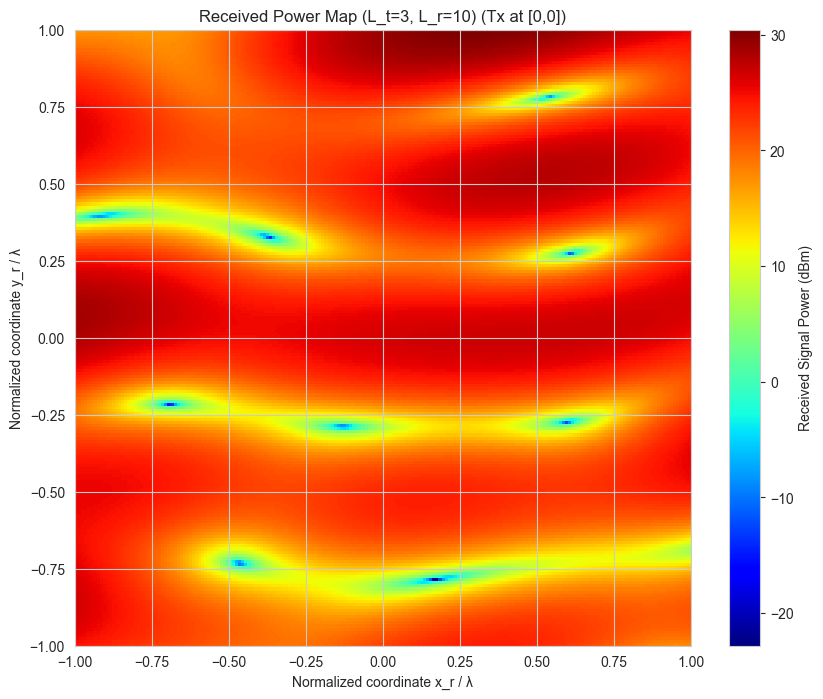


--- MA vs FPA 성능 비교 ---
FPA 수신 전력: 2.63e+01 dBm
MA (영역 내 최대) 수신 전력: 3.04e+01 dBm
성능 향상 (Gain): 4.09 dB


In [119]:
# --- 2D 수신 영역 전체의 수신 전력 맵 계산 ---

print(f"2D 수신 영역({A_normalized}λ x {A_normalized}λ)의 전력 맵을 계산합니다...")

# Tx 위치 고정 (t_pos_fixed)
g_t_fixed = calculate_g_t(t_pos_fixed, theta_t, phi_t, lambda_wave)

# Rx 위치 그리드 생성
x_r_vals = np.linspace(-A/2, A/2, grid_points)
y_r_vals = np.linspace(-A/2, A/2, grid_points)

# 결과를 저장할 2D 배열
received_power_map = np.zeros((grid_points, grid_points))
small_scale_gain_map_linear = np.zeros((grid_points, grid_points)) # 이득 맵(참고용)

# 2D 그리드를 순회하며 각 위치의 수신 전력 계산
for i in range(grid_points):
    for j in range(grid_points):
        # 현재 Rx 위치 [x_r, y_r]
        r_current = np.array([x_r_vals[i], y_r_vals[j]])

        # (1) f(r) 계산
        f_r_current = calculate_f_r(r_current, theta_r, phi_r, lambda_wave)

        # (2) h(t,r) 계산 (g_t는 고정값 사용)
        h_tr_current = calculate_channel_coefficient(g_t_fixed, f_r_current, sigma_matrix)

        # (3) 채널 이득 |h(t,r)|^2 계산
        gain_current_linear = calculate_channel_gain(h_tr_current)
        small_scale_gain_map_linear[j, i] = gain_current_linear

        # (4) 수신 전력 계산 및 저장 (dBm)
        received_power_map[j, i] = calculate_received_power(
            p_t_dbm,
            path_loss_db,
            gain_current_linear
        )

# --- 시각화 ---
# 축 레이블을 파장(lambda) 단위로 변경
extent = [-A_normalized/2, A_normalized/2, -A_normalized/2, A_normalized/2]

plt.figure(figsize=(10, 8))
im = plt.imshow(received_power_map,
                extent=extent,
                origin='lower',
                aspect='equal',
                cmap='jet')

plt.colorbar(im, label='Received Signal Power (dBm)')
plt.xlabel('Normalized coordinate x_r / λ')
plt.ylabel('Normalized coordinate y_r / λ')
plt.title(f'Received Power Map (L_t={L_t}, L_r={L_r}) (Tx at [0,0])')
plt.show()

# FPA (Fixed-Position Antenna)와의 비교
fpa_pos = np.array([0.0, 0.0]) # FPA가 영역 중앙(0,0)에 있다고 가정
# 영역 [-A/2, A/2] 내에서 임의의 (x, y) 위치를 랜덤하게 산정
# half_A = A / 2
# fpa_pos_x = np.random.uniform(-half_A, half_A)
# fpa_pos_y = np.random.uniform(-half_A, half_A)
# fpa_pos = np.array([fpa_pos_x, fpa_pos_y])

# FPA 성능 계산
f_r_fpa = calculate_f_r(fpa_pos, theta_r, phi_r, lambda_wave)
h_tr_fpa = calculate_channel_coefficient(g_t_fixed, f_r_fpa, sigma_matrix)
gain_fpa_linear = calculate_channel_gain(h_tr_fpa)
power_fpa = calculate_received_power(
    p_t_dbm,
    path_loss_db,
    gain_fpa_linear
)

power_ma_max = np.max(received_power_map)

print(f"\n--- MA vs FPA 성능 비교 ---")
# print(f"FPA (at [{fpa_pos_x:.2f}m, {fpa_pos_y:.2f}m]) 수신 전력: {power_fpa:.2e} dBm")
print(f"FPA 수신 전력: {power_fpa:.2e} dBm")
print(f"MA (영역 내 최대) 수신 전력: {power_ma_max:.2e} dBm")
# dB 스케일에서는 뺄셈이 곧 비율(Gain)을 의미합니다.
print(f"성능 향상 (Gain): {power_ma_max - power_fpa:.2f} dB")